In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random

In [2]:
class Robot:
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)


In [3]:
def run_P(robot, tau, n=100, speed=1.0):
    '''
    Proportional (P) Control
    steering = -tau * crosstrack_error
    '''
    x_trajectory = []
    y_trajectory = []
    
    for i in range(n):
        cte = robot.y
        robot.move(-cte*tau, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

In [4]:
def run_PD(robot, tau_p, tau_d, n=100, speed=1.0):
    '''
    Proportional Differential (PD) Control
    steering = -tau_p * CTE - tau_d * diff_CTE
    diff_CTE =  CTE(t) - CTE(t-1)
    '''
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.x
    
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        steer = - tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        prev_cte = cte
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

In [5]:
def run_PID(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    '''
    Proportional Integral Differential (PID) Control
    diff_CTE =  CTE(t) - CTE(t-1)
    steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
    where the integrated crosstrack error (int_CTE) is
    the sum of all the previous crosstrack errors.
    This term works to cancel out steering drift.
    '''
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.x
    int_cte = 0
    
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        steer = - tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        prev_cte = cte
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

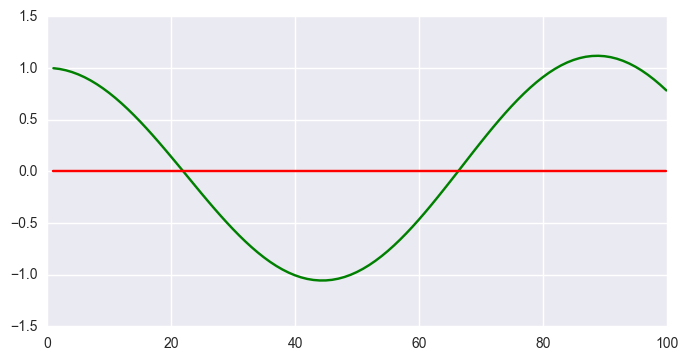

In [6]:
robot = Robot()
robot.set(0, 1, 0)
    
x_trajectory, y_trajectory = run_P(robot, 0.1)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

In [7]:
robot = Robot()

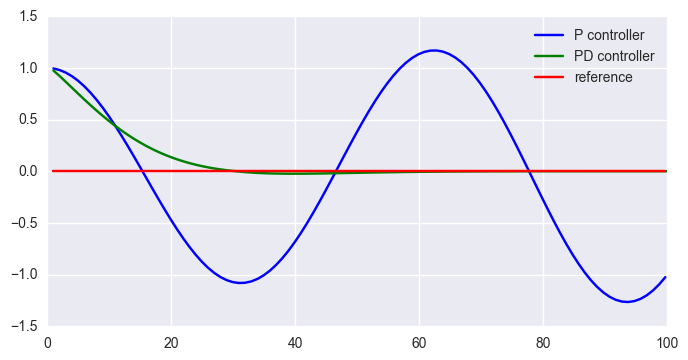

In [8]:
robot.set(0, 1, 0)
x1_trajectory, y1_trajectory = run_PD(robot, 0.2, 3.0)
robot.set(0, 1, 0)
x_trajectory, y_trajectory = run_P(robot, 0.2)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'b', label='P controller')
ax1.plot(x1_trajectory, y1_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend(loc=1)

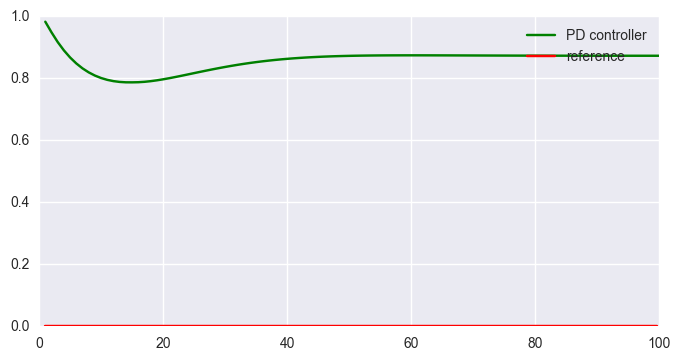

In [9]:
robot.set(0, 1, 0)
robot.set_steering_drift(10 * np.pi / 180)
x1_trajectory, y1_trajectory = run_PD(robot, 0.2, 3.0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

ax1.plot(x1_trajectory, y1_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend(loc=1)

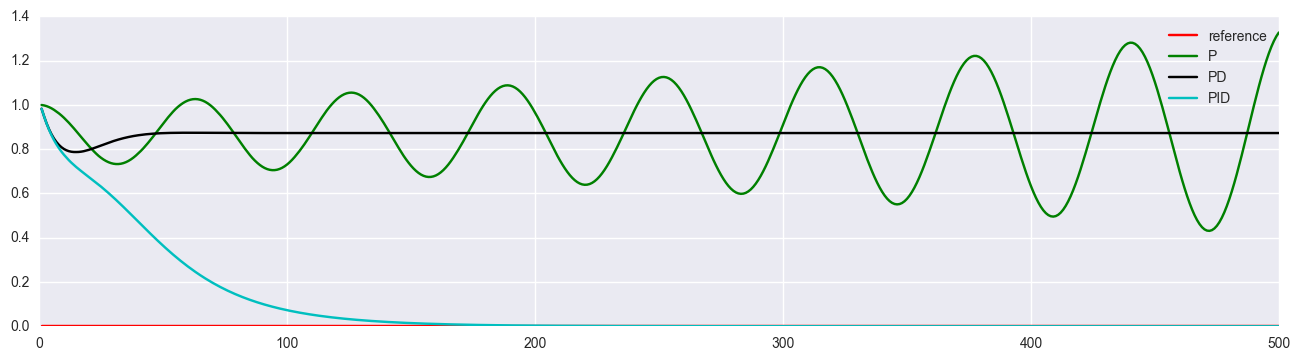

In [10]:
n = 500

robot.set(0, 1, 0)
#robot.set_steering_drift(10 * np.pi / 180)
x1_trajectory, y1_trajectory = run_P(robot, 0.2, n)

robot.set(0, 1, 0)
robot.set_steering_drift(10 * np.pi / 180)
x2_trajectory, y2_trajectory = run_PD(robot, 0.2, 3.0, n)

robot.set(0, 1, 0)
robot.set_steering_drift(10 * np.pi / 180)
x3_trajectory, y3_trajectory = run_PID(robot, 0.2, 3.0, 0.004, n)

fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))
ax1.plot(x2_trajectory, np.zeros(n), 'r', label='reference')

ax1.plot(x1_trajectory, y1_trajectory, 'g', label="P")
ax1.plot(x2_trajectory, y2_trajectory, 'k', label='PD')
ax1.plot(x3_trajectory, y3_trajectory, 'c', label='PID')

ax1.legend(loc=1)

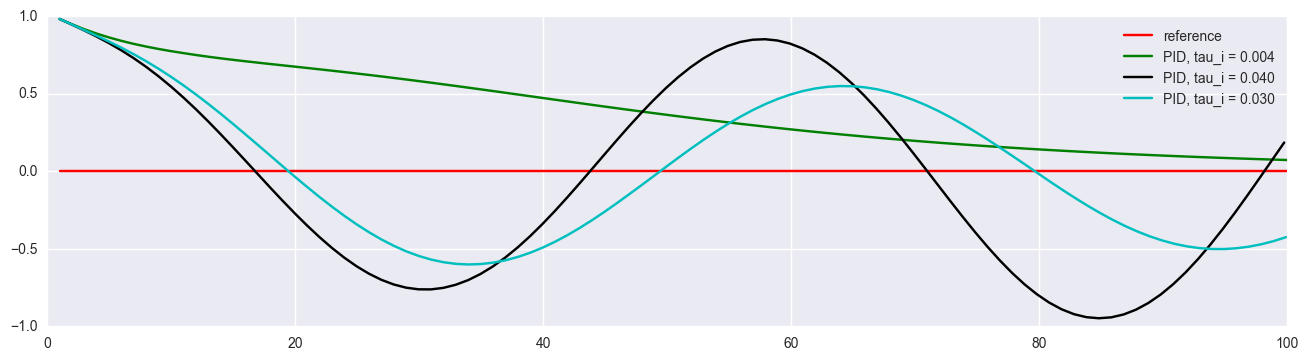

In [11]:
n = 100
tau_i = 0.03

robot.set(0, 1, 0)
robot.set_steering_drift(10 * np.pi / 180)
x2_trajectory, y2_trajectory = run_PID(robot, 0.2, 3.0, 0.004, n)

robot.set(0, 1, 0)
robot.set_steering_drift(10 * np.pi / 180)
x3_trajectory, y3_trajectory = run_PID(robot, 0.2, 3.0, 0.04, n)

robot.set(0, 1, 0)
robot.set_steering_drift(10 * np.pi / 180)
x4_trajectory, y4_trajectory = run_PID(robot, 0.2, 3.0, tau_i, n)

fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))
ax1.plot(x2_trajectory, np.zeros(n), 'r', label='reference')

ax1.plot(x2_trajectory, y2_trajectory, 'g', label="PID, tau_i = %.3f" % 0.004)
ax1.plot(x3_trajectory, y3_trajectory, 'k', label='PID, tau_i = %.3f' % 0.04)
ax1.plot(x4_trajectory, y4_trajectory, 'c', label='PID, tau_i = %.3f' % tau_i)

ax1.legend(loc=1)

In [21]:
def twiddle(tol=0.2, speed=1.0): 
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p, speed=speed)
    counter = 0
    while sum(dp) > tol:
        for i in range(len(p)):
            robot = make_robot()
            p[i] += dp[i]
            x_trajectory, y_trajectory, err = run(robot, p, speed=speed)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p, speed=speed)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        counter += 1
    
    return p, best_err, counter

In [22]:
def make_robot():
    """
    Resets the robot back to the initial position and drift.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot

In [23]:
def run(robot, params, n=100, speed=1.0):
    tau_p, tau_d, tau_i = params
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

Final twiddle error = 3.0842684885009004e-06 obtained in 42 steps
best params = 0.27974800367751146, 3.020058104789998, 0.4972721290440295


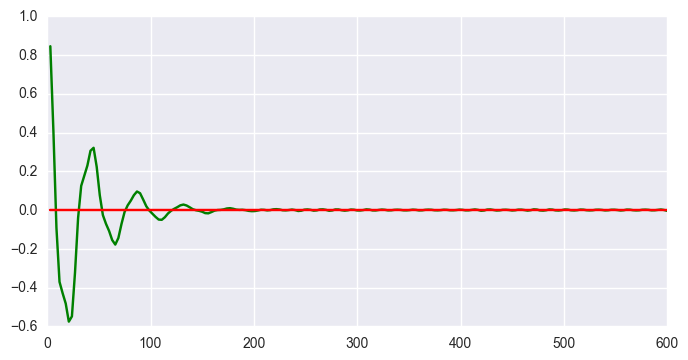

In [31]:
SPEED = 3.0
params, err, counter = twiddle(tol=0.1, speed=SPEED)
print("Final twiddle error = {} obtained in {} steps".format(err, counter))
print('best params = {}, {}, {}'.format(params[0], params[1], params[2]))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params, speed=SPEED)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
